In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
%matplotlib inline
import numpy as np
import scipy.ndimage.filters as flt
import warnings
from PIL import Image
import copy

In [26]:
def anisodiff(img,niter=200,kappa=10,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False):
    if img.ndim == 3:
        warnings.warn("Only grayscale images allowed, converting to 2D matrix")
        img = img.mean(2)

    # initialize output array
    img = img.astype('float32')
    imgout = img.copy()

    # initialize some internal variables
    deltaS = np.zeros_like(imgout)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(imgout)
    gE = gS.copy()
    
    if ploton:
        import pylab as pl
        from time import sleep

        fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
        ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

        ax1.imshow(img,interpolation='nearest')
        ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
        ax1.set_title("Original image")
        ax2.set_title("Iteration 0")

        fig.canvas.draw()
        
    for ii in np.arange(1,niter):

        # calculate the diffs
        deltaS[:-1,: ] = np.diff(imgout,axis=0)
        deltaE[: ,:-1] = np.diff(imgout,axis=1)

        if 0<sigma:
            deltaSf=flt.gaussian_filter(deltaS,sigma);
            deltaEf=flt.gaussian_filter(deltaE,sigma);
        else: 
            deltaSf=deltaS;
            deltaEf=deltaE;

        # conduction gradients (only need to compute one per dim!)
        if option == 1:
            gS = np.exp(-(deltaSf/kappa)**2.)/step[0]
            gE = np.exp(-(deltaEf/kappa)**2.)/step[1]
        elif option == 2:
            gS = 1./(1.+(deltaSf/kappa)**2.)/step[0]
            gE = 1./(1.+(deltaEf/kappa)**2.)/step[1]
            
        E = gE*deltaE
        S = gS*deltaS

        # subtract a copy that has been shifted 'North/West' by one
        # pixel. don't as questions. just do it. trust me.
        NS[:] = S
        EW[:] = E
        NS[1:,:] -= S[:-1,:]
        EW[:,1:] -= E[:,:-1]

        # update the image
        imgout += gamma*(NS+EW)

        if ploton:
            iterstring = "Iteration %i" %(ii+1)
            ih.set_data(imgout)
            ax2.set_title(iterstring)
            fig.canvas.draw()
            # sleep(0.01)

    return imgout


In [27]:
def colorful_diffusion(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False):
    result = copy.deepcopy(img)
    row = len(img)
    column = len(img[0])
    image_r = img[0:row, 0:column, 0]
    image_g = img[0:row, 0:column, 1]
    image_b = img[0:row, 0:column, 2]
    for i in range(1):
        image_r=anisodiff(image_r)
        image_g=anisodiff(image_g)
        image_b=anisodiff(image_b)
    for i in range(len(img)):
        for j in range(len(img[0])):
            result[i][j][0] = image_r[i][j]
            result[i][j][1] = image_g[i][j]
            #result[i][j][1] = img[i][j][1]
            result[i][j][2] = image_b[i][j]
            #result[i][j][2] = 255
    return result

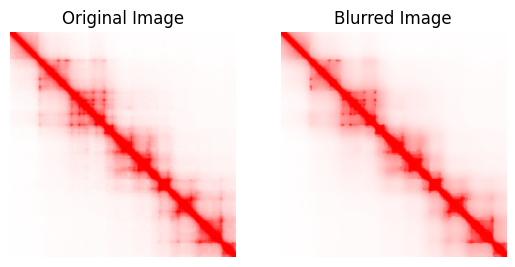

In [28]:
valid_image = 0
while valid_image == 0:
    #img_name = input("Please input the name of the image: ")
    img_name = "hic_example3.png"
    try:
        img = Image.open(img_name)
        valid_image = 1
    except:
        print("wrong input")
#local_lambda = eval(input("Please input lambda: "))
#kappa = eval(input("Please input kappa: "))
#loop = int(input("Please input number of loops: "))
original_image = np.asarray(img)
blurred_image_array = colorful_diffusion(original_image)

#save the blurred image
blurred_image = Image.fromarray(blurred_image_array)
if img_name[-3:] == "png":
    blurred_image.save("blurred_image.png")
else:
    blurred_image.save("blurred_image.jpg")

#print the original image and the result image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(blurred_image)
plt.title('Blurred Image')
plt.axis('off')

plt.show()